## Importing Packages

In [156]:
from math import sin, cos
import s2cell

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.max_columns', 500)

In [2]:
samp_df = pd.read_csv('sample_submission.csv')

In [3]:
test_df = pd.read_csv('data_test.csv')

In [4]:
train_df = pd.read_csv('data_train.csv')

In [5]:
raw_irre_df = pd.read_csv('irregularities.csv')

In [6]:
raw_alerts_df = pd.read_csv('alerts.csv')

## Checking Raw Dataset

> #### Data Sample Submission CSV

In [7]:
samp_df.head(3)

,Ids,Labels
0,2e69c8bc4_2020-11-29_18,False
1,2e6992f24_2020-11-27_18,True
2,2e69e8dfc_2020-11-28_15,True


In [8]:
samp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ids     200 non-null    object
 1   Labels  200 non-null    bool  
dtypes: bool(1), object(1)
memory usage: 1.9+ KB


> #### Data Test CSV

In [9]:
test_df.head(3)

,Ids
0,2e6992a84_2020-11-25_18
1,2e68e62f4_2020-11-29_20
2,2e68e81a4_2020-11-27_10


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13841 entries, 0 to 13840
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ids     13841 non-null  object
dtypes: object(1)
memory usage: 108.3+ KB


> #### Data Train CSV

In [11]:
train_df.head(3)

,Ids,Labels
0,2e69e9384_2020-10-06_13,True
1,2e6992c7c_2020-10-02_17,True
2,2e69ef474_2020-09-13_19,True


In [12]:
train_df['Ids'].min()

'2e68c2584_2020-11-08_9'

In [13]:
train_df['Ids'].max()

'2e6a27984_2020-10-27_20'

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71336 entries, 0 to 71335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ids     71336 non-null  object
 1   Labels  71336 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 627.1+ KB


> #### Data Irregularities CSV

In [15]:
raw_irre_df.head(3)

,id,detection_date_millis,update_date_millis,street,city,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type,severity,jam_level,drivers_count,alerts_count,n_thumbs_up
0,12868069,1604733149024,1604735467276,Jatiwaringin Raya,Bekasi,t,"{""line"": [{""x"": 106.91014, ""y"": -6.258107}, {""...",3344471185277583360,2e69f2d2c,13.03,17.15,299,432,1566,0,Small,5,3,13,0,0
1,12420463,1599906813144,1599909295834,Putri Tunggal,Depok,f,"{""line"": [{""x"": 106.887821, ""y"": -6.377016}, {...",3344462996922433536,2e69eb604,6.56,18.00,399,539,984,0,Small,5,3,5,0,0
2,12497533,1601728355356,1601734996933,Ir Haji Juanda,Bandung,f,"{""line"": [{""x"": 107.618629, ""y"": -6.87556}, {""...",3344176694402482176,2e68e6fc4,3.36,19.65,1185,1294,1212,1,Large,5,4,21,2,0


In [16]:
raw_irre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352609 entries, 0 to 352608
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     352609 non-null  int64  
 1   detection_date_millis  352609 non-null  int64  
 2   update_date_millis     352609 non-null  int64  
 3   street                 349773 non-null  object 
 4   city                   352609 non-null  object 
 5   is_highway             352609 non-null  object 
 6   line                   352609 non-null  object 
 7   s2id_center            352609 non-null  int64  
 8   s2token_center         352609 non-null  object 
 9   speed                  352609 non-null  float64
 10  regular_speed          352609 non-null  float64
 11  delay_seconds          352609 non-null  int64  
 12  seconds                352609 non-null  int64  
 13  length                 352609 non-null  int64  
 14  trend                  352609 non-nu

In [17]:
raw_irre_df.describe(include='all')

,id,detection_date_millis,update_date_millis,street,city,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type,severity,jam_level,drivers_count,alerts_count,n_thumbs_up
count,3.526090e+05,3.526090e+05,3.526090e+05,349773,352609,352609,352609,3.526090e+05,352609,352609.000000,352609.000000,352609.000000,352609.000000,352609.000000,352609.000000,352609,352609.0,352609.000000,352609.000000,352609.000000,352609.000000
unique,NaN,NaN,NaN,408,21,2,22501,NaN,1914,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Trans Yogi,Bandung,t,"{""line"": [{""x"": 106.76179, ""y"": -6.405493}, {""...",NaN,2e69e8dfc,NaN,NaN,NaN,NaN,NaN,NaN,Small,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,23480,103670,212915,5690,NaN,9877,NaN,NaN,NaN,NaN,NaN,NaN,216308,NaN,NaN,NaN,NaN,NaN
mean,1.267873e+07,1.603120e+12,1.603123e+12,NaN,NaN,NaN,NaN,3.344336e+18,NaN,7.084055,19.611386,666.748478,806.608754,1466.211169,-0.171865,NaN,5.0,3.676041,11.678377,0.460102,0.157585
std,2.084245e+05,1.993569e+09,1.993727e+09,NaN,NaN,NaN,NaN,1.137887e+14,NaN,3.461805,9.268717,365.584715,398.243550,836.260998,0.790400,NaN,0.0,0.507719,10.889130,0.957061,0.773910
min,1.232382e+07,1.598915e+12,1.598916e+12,NaN,NaN,NaN,NaN,3.344136e+18,NaN,0.570000,-1.000000,63.000000,104.000000,500.000000,-1.000000,NaN,5.0,1.000000,1.000000,0.000000,0.000000
25%,1.249558e+07,1.601721e+12,1.601724e+12,NaN,NaN,NaN,NaN,3.344178e+18,NaN,4.600000,13.530000,440.000000,549.000000,852.000000,-1.000000,NaN,5.0,3.000000,5.000000,0.000000,0.000000
50%,1.266650e+07,1.603710e+12,1.603712e+12,NaN,NaN,NaN,NaN,3.344362e+18,NaN,6.390000,18.370000,595.000000,726.000000,1230.000000,0.000000,NaN,5.0,4.000000,8.000000,0.000000,0.000000
75%,1.286050e+07,1.604719e+12,1.604721e+12,NaN,NaN,NaN,NaN,3.344460e+18,NaN,8.800000,23.910000,808.000000,973.000000,1846.000000,0.000000,NaN,5.0,4.000000,14.000000,1.000000,0.000000


In [18]:
# Checking raw datasets

desc = []
for i in raw_irre_df.columns:
    desc.append([i,
                raw_irre_df[i].dtypes,
                raw_irre_df[i].isna().sum(),
                round((raw_irre_df[i].isna().sum())/len(raw_irre_df)*100,2),
                raw_irre_df[i].nunique(),
                raw_irre_df[i].sample(2).values])
pd.DataFrame(desc, columns = ['dataFeatures', 'dataType',' null', 'nullPct', 'unique', 'uniqueSample'])

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,id,int64,0,0.0,252609,"[12787954, 13050081]"
1,detection_date_millis,int64,0,0.0,14830,"[1601805401236, 1604806445253]"
2,update_date_millis,int64,0,0.0,174739,"[1601028187001, 1600833436577]"
3,street,object,2836,0.8,408,"[Arah Cikarang Barat/Lemahabang, Cikutra Barat]"
4,city,object,0,0.0,21,"[Depok, Bandung]"
5,is_highway,object,0,0.0,2,"[f, t]"
6,line,object,0,0.0,22501,"[{""line"": [{""x"": 106.949024, ""y"": -6.24963}, {..."
7,s2id_center,int64,0,0.0,1914,"[3344176509718888448, 3344360609197064192]"
8,s2token_center,object,0,0.0,1914,"[2e6992b14, 2e68e6b64]"
9,speed,float64,0,0.0,2518,"[4.16, 6.36]"


In [19]:
a_tes1 = dt.datetime.fromtimestamp(raw_irre_df['detection_date_millis'][0]/1000.0)  # checking

In [20]:
a_tes2 = dt.datetime.fromtimestamp(raw_irre_df['update_date_millis'][0]/1000.0)  # checking

In [21]:
a_tes1, a_tes2

(datetime.datetime(2020, 11, 7, 14, 12, 29, 24000),
 datetime.datetime(2020, 11, 7, 14, 51, 7, 276000))

> #### Alerts CSV

In [22]:
raw_alerts_df.head(3)

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846
1,179156987,1604487892000,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,NaN,1,1,JAM,JAM_HEAVY_TRAFFIC,NaN,0.0,106.867141,-6.383855
2,181688703,1605666614000,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.921974,-6.379087


In [23]:
raw_alerts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800662 entries, 0 to 7800661
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int64  
 1   pub_millis                   int64  
 2   s2id_15                      int64  
 3   s2token_15                   object 
 4   road_type                    int64  
 5   street                       object 
 6   city                         object 
 7   magvar                       int64  
 8   reliability                  int64  
 9   report_description           float64
 10  report_rating                int64  
 11  confidence                   int64  
 12  type                         object 
 13  subtype                      object 
 14  report_by_municipality_user  float64
 15  n_thumbs_up                  float64
 16  longitude                    float64
 17  latitude                     float64
dtypes: float64(5), int64(8), object(5)
memory 

In [24]:
raw_alerts_df.describe(include='all')

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude
count,7.800662e+06,7.800662e+06,7.800662e+06,7800662,7.800662e+06,6668993,7800662,7.800662e+06,7.800662e+06,0.0,7.800662e+06,7.800662e+06,7800662,7603664,0.0,2515124.0,7.800662e+06,7.800662e+06
unique,NaN,NaN,NaN,4341,NaN,2144,20,NaN,NaN,NaN,NaN,NaN,4,26,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,2e68e64c4,NaN,Ir Haji Juanda,Bandung,NaN,NaN,NaN,NaN,NaN,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,265609,NaN,626736,4463547,NaN,NaN,NaN,NaN,NaN,4269581,4268894,NaN,NaN,NaN,NaN
mean,1.740590e+08,1.602244e+12,3.344264e+18,NaN,3.846760e+00,NaN,NaN,8.904586e+01,6.443702e+00,NaN,1.176968e+00,3.812903e-01,NaN,NaN,NaN,0.0,1.073486e+02,-6.671771e+00
std,4.744770e+06,2.021204e+09,1.066108e+14,NaN,2.883360e+00,NaN,NaN,1.258826e+02,1.504663e+00,NaN,1.696724e+00,1.018619e+00,NaN,NaN,NaN,0.0,3.222071e-01,2.960890e-01
min,1.662550e+08,1.598895e+12,3.344136e+18,NaN,1.000000e+00,NaN,NaN,0.000000e+00,5.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.0,1.067135e+02,-6.968834e+00
25%,1.699264e+08,1.600524e+12,3.344176e+18,NaN,2.000000e+00,NaN,NaN,0.000000e+00,6.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.0,1.070087e+02,-6.919966e+00
50%,1.734051e+08,1.602122e+12,3.344178e+18,NaN,2.000000e+00,NaN,NaN,0.000000e+00,6.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.0,1.076032e+02,-6.893167e+00
75%,1.779916e+08,1.603854e+12,3.344362e+18,NaN,7.000000e+00,NaN,NaN,1.870000e+02,6.000000e+00,NaN,2.000000e+00,0.000000e+00,NaN,NaN,NaN,0.0,1.076130e+02,-6.346568e+00


In [25]:
# Checking raw datasets

desc = []
for i in raw_alerts_df.columns:
    desc.append([i,
                raw_alerts_df[i].dtypes,
                raw_alerts_df[i].isna().sum(),
                round((raw_alerts_df[i].isna().sum())/len(raw_alerts_df)*100,2),
                raw_alerts_df[i].nunique(),
                raw_alerts_df[i].sample(2).values])
pd.DataFrame(desc, columns = ['dataFeatures', 'dataType',' null', 'nullPct', 'unique', 'uniqueSample'])

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,id,int64,0,0.00,6800662,"[168188280, 170923354]"
1,pub_millis,int64,0,0.00,55193,"[1604913863000, 1601604035000]"
2,s2id_15,int64,0,0.00,4341,"[3344359591289815040, 3344178468223975424]"
3,s2token_15,object,0,0.00,4341,"[2e68e6b94, 2e6a20ba4]"
4,road_type,int64,0,0.00,10,"[7, 7]"
5,street,object,1131669,14.51,2144,"[nan, Mohammad Ramdan]"
6,city,object,0,0.00,20,"[Serang Baru, Bandung]"
7,magvar,int64,0,0.00,360,"[0, 0]"
8,reliability,int64,0,0.00,6,"[5, 8]"
9,report_description,float64,7800662,100.00,0,"[nan, nan]"


## Preprocessing

> #### Adding "Ids" Column in "Alerts"

In [26]:
alerts_df = raw_alerts_df.copy()

In [27]:
alerts_df.head(3)

,id,pub_millis,s2id_15,s2token_15,road_type,street,city,magvar,reliability,report_description,report_rating,confidence,type,subtype,report_by_municipality_user,n_thumbs_up,longitude,latitude
0,177876895,1603331480000,3344466888162803712,2e69eeea4,1,NaN,Depok,0,9,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.788545,-6.359846
1,179156987,1604487892000,3344463130066419712,2e69eb7f4,6,N8 Jalan Raya Bogor,Depok,170,7,NaN,1,1,JAM,JAM_HEAVY_TRAFFIC,NaN,0.0,106.867141,-6.383855
2,181688703,1605666614000,3344367648648462336,2e6994a84,7,NaN,Bekasi,0,8,NaN,0,1,ROAD_CLOSED,ROAD_CLOSED_EVENT,NaN,NaN,106.921974,-6.379087


In [28]:
alerts_df['dates'] = [dt.datetime.fromtimestamp(i/1000.0) for i in alerts_df['pub_millis']]

In [29]:
alerts_df['dates'][:3]  # checking

0   2020-10-22 08:51:20
1   2020-11-04 18:04:52
2   2020-11-18 09:30:14
Name: dates, dtype: datetime64[ns]

In [30]:
alerts_df['date'] = [i.strftime("%Y-%m-%d") for i in alerts_df['dates']]
alerts_df['hour'] = [i.strftime("%H") for i in alerts_df['dates']]
alerts_df['hour'] = alerts_df['hour'].str.replace("0", "", 1)
alerts_df['Ids'] = alerts_df.s2token_15 + '_' + alerts_df.date + '_' + alerts_df.hour

In [31]:
alerts_df[['Ids']]  # checking

,Ids
0,2e69eeea4_2020-10-22_8
1,2e69eb7f4_2020-11-04_18
2,2e6994a84_2020-11-18_9
3,2e699ad9c_2020-10-05_18
4,2e69eec0c_2020-10-12_7
...,...
7800657,2e68e6564_2020-09-28_9
7800658,2e698a284_2020-10-04_18
7800659,2e68e64cc_2020-09-02_9
7800660,2e69927fc_2020-10-07_19


> #### Adding "Ids" Column in "Irregularities"

In [32]:
irre_df = raw_irre_df.copy()

In [33]:
irre_df.head(3)

,id,detection_date_millis,update_date_millis,street,city,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type,severity,jam_level,drivers_count,alerts_count,n_thumbs_up
0,12868069,1604733149024,1604735467276,Jatiwaringin Raya,Bekasi,t,"{""line"": [{""x"": 106.91014, ""y"": -6.258107}, {""...",3344471185277583360,2e69f2d2c,13.03,17.15,299,432,1566,0,Small,5,3,13,0,0
1,12420463,1599906813144,1599909295834,Putri Tunggal,Depok,f,"{""line"": [{""x"": 106.887821, ""y"": -6.377016}, {...",3344462996922433536,2e69eb604,6.56,18.00,399,539,984,0,Small,5,3,5,0,0
2,12497533,1601728355356,1601734996933,Ir Haji Juanda,Bandung,f,"{""line"": [{""x"": 107.618629, ""y"": -6.87556}, {""...",3344176694402482176,2e68e6fc4,3.36,19.65,1185,1294,1212,1,Large,5,4,21,2,0


In [34]:
irre_df['dates'] = [dt.datetime.fromtimestamp(i/1000.0) for i in irre_df['detection_date_millis']]

In [35]:
irre_df['dates'][:3]  # checking

0   2020-11-07 14:12:29.024
1   2020-09-12 17:33:33.144
2   2020-10-03 19:32:35.356
Name: dates, dtype: datetime64[ns]

In [36]:
irre_df['date'] = [i.strftime("%Y-%m-%d") for i in irre_df['dates']]
irre_df['hour'] = [i.strftime("%H") for i in irre_df['dates']]
irre_df['hour'] = irre_df['hour'].str.replace("0", "", 1)
irre_df['Ids'] = irre_df.s2token_center + '_' + irre_df.date + '_' + irre_df.hour

In [37]:
irre_df[['Ids']]  # checking

,Ids
0,2e69f2d2c_2020-11-07_14
1,2e69eb604_2020-09-12_17
2,2e68e6fc4_2020-10-03_19
3,2e698c034_2020-10-10_13
4,2e698e5bc_2020-09-01_17
...,...
352604,2e69c41c4_2020-09-05_13
352605,2e68e8144_2020-10-18_14
352606,2e6984e2c_2020-11-01_23
352607,2e68e71fc_2020-10-31_1


> #### Combining "Alerts" and "Irregularities"

In [38]:
comb_df = pd.merge(alerts_df, irre_df, on='Ids')

In [39]:
# comb_df = pd.merge(alerts_df, irre_df, left_on=['Ids', 's2token_15', 's2id_15', 'street'], right_on=['Ids', 's2token_center', 's2id_center', 'street'])  # checking

In [40]:
comb_df = pd.merge(train_df, comb_df, on='Ids')

In [41]:
comb_df

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_description,report_rating,confidence,type_x,subtype,report_by_municipality_user,n_thumbs_up_x,longitude,latitude,dates_x,date_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,dates_y,date_y,hour_y
0,2e68e7d0c_2020-10-14_17,True,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,NaN,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565640,1602671143526,1602672140763,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.21,19.21,514,583,683,0,Medium,5,4,5,6,3,2020-10-14 17:25:43.526,2020-10-14,17
1,2e68e7d0c_2020-10-14_17,True,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,NaN,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565622,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17
2,2e68e7d0c_2020-10-14_17,True,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,NaN,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565631,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17
3,2e68e7d0c_2020-10-14_17,True,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,NaN,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565651,1602671143526,1602672216632,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.15,19.47,522,591,683,0,Medium,5,4,5,6,3,2020-10-14 17:25:43.526,2020-10-14,17
4,2e68e7d0c_2020-10-14_17,True,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,NaN,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565622,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188055,2e68e6874_2020-11-22_17,True,182152990,1606041616000,3344176191891308544,2e68e6874,2,Prof Dr Surya Sumantri,Bandung,181,6,NaN,1,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,107.581387,-6.886732,2020-11-22 17:40:16,2020-11-22,17,13058773,1606041892092,1606043055591,Prof Dr Surya Sumantri,Bandung,f,"{""line"": [{""x"": 107.58148, ""y"": -6.882219}, {""...",3344176191891308544,2e68e6874,3.97,16.06,847,935,1033,1,Medium,5,4,8,2,1,2020-11-22 17:44:52.092,2020-11-22,17
3188056,2e68e6874_2020-11-22_17,True,182152990,1606041616000,3344176191891308544,2e68e6874,2,Prof Dr Surya Sumantri,Bandung,181,6,NaN,1,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,107.581387,-6.886732,2020-11-22 17:40:16,2020-11-22,17,13058747,1606041892092,1606043055591,Prof Dr Surya Sumantri,Bandung,f,"{""line"": [{""x"": 107.58148, ""y"": -6.882219}, {""...",3344176191891308544,2e68e6874,3.97,16.06,847,935,1033,1,Medium,5,4,8,2,1,2020-11-22 17:44:52.092,2020-11-22,17
3188057,2e68e6874_2020-11-22_17,True,182152990,1606041616000,3344176191891308544,2e68e6874,2,Prof Dr Surya Sumantri,Bandung,181,6,NaN,1,0,JAM,JAM_HEAVY_TRAFFIC,NaN,NaN,107.581387,

In [42]:
(comb_df.isna().sum()/len(comb_df)*100).nlargest(10)

report_description             100.000000
report_by_municipality_user    100.000000
n_thumbs_up_x                   75.327064
subtype                          5.002415
street_x                         3.020614
street_y                         0.969367
Ids                              0.000000
Labels                           0.000000
id_x                             0.000000
pub_millis                       0.000000
dtype: float64

> #### Removing Features

In [43]:
comb_df.drop(columns=['report_description', 'report_by_municipality_user'], inplace=True)

> #### Converting Labels to Zeros and Ones

In [44]:
comb_df['Labels'] = np.where(comb_df['Labels']==True, 1, 0)

In [45]:
comb_df.head(3)

,Ids,Labels,id_x,pub_millis,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_rating,confidence,type_x,subtype,n_thumbs_up_x,longitude,latitude,dates_x,date_x,hour_x,id_y,detection_date_millis,update_date_millis,street_y,city_y,is_highway,line,s2id_center,s2token_center,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y,dates_y,date_y,hour_y
0,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565640,1602671143526,1602672140763,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.21,19.21,514,583,683,0,Medium,5,4,5,6,3,2020-10-14 17:25:43.526,2020-10-14,17
1,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565622,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17
2,2e68e7d0c_2020-10-14_17,1,174293857,1602671462000,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,NaN,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,12565631,1602671143526,1602672062891,Laswi,Bandung,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",3344177607083032576,2e68e7d0c,4.17,18.78,519,588,683,1,Medium,5,4,5,6,2,2020-10-14 17:25:43.526,2020-10-14,17


In [46]:
comb_df.columns

Index(['Ids', 'Labels', 'id_x', 'pub_millis', 's2id_15', 's2token_15',
       'road_type', 'street_x', 'city_x', 'magvar', 'reliability',
       'report_rating', 'confidence', 'type_x', 'subtype', 'n_thumbs_up_x',
       'longitude', 'latitude', 'dates_x', 'date_x', 'hour_x', 'id_y',
       'detection_date_millis', 'update_date_millis', 'street_y', 'city_y',
       'is_highway', 'line', 's2id_center', 's2token_center', 'speed',
       'regular_speed', 'delay_seconds', 'seconds', 'length', 'trend',
       'type_y', 'severity', 'jam_level', 'drivers_count', 'alerts_count',
       'n_thumbs_up_y', 'dates_y', 'date_y', 'hour_y'],
      dtype='object')

> #### Merging Columns

In [47]:
data = comb_df[['Ids', 'Labels', 's2id_15', 's2token_15', 'road_type', 'street_x', 'city_x', 'magvar', 'reliability', 'report_rating', 'confidence', 'type_x', 'subtype', 'longitude', 'latitude', 'dates_x', 'date_x', 'hour_x', 'is_highway', 'line', 'speed',
       'regular_speed', 'delay_seconds', 'seconds', 'length', 'trend', 'type_y', 'severity', 'jam_level', 'drivers_count', 'alerts_count', 'n_thumbs_up_y']]

In [48]:
data.head(3)

,Ids,Labels,s2id_15,s2token_15,road_type,street_x,city_x,magvar,reliability,report_rating,confidence,type_x,subtype,longitude,latitude,dates_x,date_x,hour_x,is_highway,line,speed,regular_speed,delay_seconds,seconds,length,trend,type_y,severity,jam_level,drivers_count,alerts_count,n_thumbs_up_y
0,2e68e7d0c_2020-10-14_17,1,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",4.21,19.21,514,583,683,0,Medium,5,4,5,6,3
1,2e68e7d0c_2020-10-14_17,1,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",4.17,18.78,519,588,683,1,Medium,5,4,5,6,2
2,2e68e7d0c_2020-10-14_17,1,3344177607083032576,2e68e7d0c,7,Laswi,Bandung,194,6,5,0,WEATHERHAZARD,HAZARD_ON_SHOULDER_CAR_STOPPED,107.631025,-6.920342,2020-10-14 17:31:02,2020-10-14,17,t,"{""line"": [{""x"": 107.630985, ""y"": -6.917677}, {...",4.17,18.78,519,588,683,1,Medium,5,4,5,6,2


In [49]:
# Checking

print(len(data.columns))
print(comb_df['s2token_15'].nunique())

32
930


- __Determining the Labels__

In [50]:
data[data['Labels']==1]['jam_level'].value_counts()

4    2377452
3     689364
2      21067
1        926
Name: jam_level, dtype: int64

In [51]:
data[data['Labels']==0]['jam_level'].value_counts()

4    74803
3    23117
2     1331
Name: jam_level, dtype: int64

1 is High Jam Reports and 0 is No Congestion 

Text(0.5, 1.0, 'Ratio Between High Jam Reports (1) and No Congestion (0)')

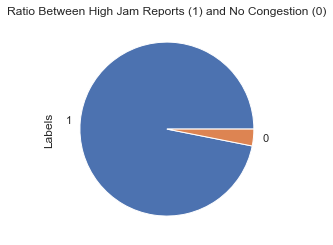

In [52]:
# Data is highly unbalanced, balancing method needs to be implemented

data['Labels'].value_counts(normalize=True).plot(kind='pie')
plt.title('Ratio Between High Jam Reports (1) and No Congestion (0)')

In [53]:
data_ml = data[['latitude', 'longitude', 'date_x', 'hour_x', 'Labels']]
data_ml.rename(columns={'date_x': 'date', 'hour_x': 'hour'}, inplace=True)

In [54]:
data_ml['date'] = data_ml['date'].str.split('-')

In [55]:
data_ml['year'] = data_ml['date'].apply(lambda x: int(x[0]))
data_ml['month'] = data_ml['date'].apply(lambda x: int(x[1]))
data_ml['day'] = data_ml['date'].apply(lambda x: int(x[2]))
data_ml['hour'] = data_ml['hour'].astype('int')

In [56]:
data_ml['x'] = data_ml['latitude'].apply(cos) * data_ml['longitude'].apply(cos)
data_ml['y'] = data_ml['latitude'].apply(cos) * data_ml['longitude'].apply(sin)
data_ml['z'] = data_ml['latitude'].apply(sin)

In [57]:
data_ml = data_ml[['x', 'y', 'z', 'year', 'month', 'day', 'hour', 'Labels']]

In [58]:
data_ml.head(3)

,x,y,z,year,month,day,hour,Labels
0,0.550197,0.585971,-0.594912,2020,10,14,17,1
1,0.550197,0.585971,-0.594912,2020,10,14,17,1
2,0.550197,0.585971,-0.594912,2020,10,14,17,1


> #### Selecting Feature and Target

In [59]:
X = data_ml[['x', 'y', 'z', 'year', 'month', 'day', 'hour']]
y = data_ml['Labels']

In [60]:
X.head()

,x,y,z,year,month,day,hour
0,0.550197,0.585971,-0.594912,2020,10,14,17
1,0.550197,0.585971,-0.594912,2020,10,14,17
2,0.550197,0.585971,-0.594912,2020,10,14,17
3,0.550197,0.585971,-0.594912,2020,10,14,17
4,0.550197,0.585971,-0.594912,2020,10,14,17


In [61]:
y[:5]

0    1
1    1
2    1
3    1
4    1
Name: Labels, dtype: int32

> #### Splitting Training-validation Set and Testing Set

In [62]:
# Splitting training-validation set dan testing set

X_train_val, X_test, y_train_val, y_test= train_test_split(X,y,stratify=y, random_state=2021,test_size=0.2)
skfold = StratifiedKFold(n_splits = 5, random_state=2021, shuffle=True)

## Creating Benchmark Models - 1

In [63]:
sklearn.metrics.SCORERS.keys() 

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

> #### Creating Logistic Regression Benchmark 

In [64]:
logreg = LogisticRegression(random_state=2021)

transformer_logreg_bench = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour'])
], remainder='passthrough')

pipe_logreg_bench = imbPipeline([
    ('transformer', transformer_logreg_bench),
    ('logreg', logreg)
])

In [65]:
logreg_bench_cv = cross_val_score(pipe_logreg_bench, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV Logreg Benchmark:', logreg_bench_cv)
print('CV Logreg Benchmark Mean:', logreg_bench_cv.mean())
# CV Logreg Benchmark: [0.98398971 0.98398161 0.98401905 0.98396944 0.98398563]
# CV Logreg Benchmark Mean: 0.9839890860990159

CV Logreg Benchmark: [0.98398971 0.98398161 0.98401905 0.98396944 0.98398563]
CV Logreg Benchmark Mean: 0.9839890860990159


> #### Creating Decision Tree Classifier Benchmark 

In [66]:
dtc = DecisionTreeClassifier(random_state=2021)

transformer_dtc_bench = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour'])
], remainder='passthrough')

pipe_dtc_bench = Pipeline([
    ('transformer', transformer_dtc_bench),
    ('dtc', dtc)
])

In [67]:
dtc_bench_cv = cross_val_score(pipe_dtc_bench, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV DTC Benchmark1:', dtc_bench_cv)
print('CV DTC Benchmark1 Mean:', dtc_bench_cv.mean())
# CV DTC Benchmark1: [1.         1.         1.         0.99999899 1.        ]
# CV DTC Benchmark1 Mean: 0.9999997976566618

CV DTC Benchmark1: [1.         1.         1.         0.99999899 1.        ]
CV DTC Benchmark1 Mean: 0.9999997976566618


> #### Creating Decision Tree Classifier Benchmark 2 - smote, PF

In [68]:
dtc = DecisionTreeClassifier(random_state=2021)
smote = SMOTE(random_state=2021)

transformer_dtc_bench2 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_dtc_bench2 = imbPipeline([
    ('transformer', transformer_dtc_bench2),
    ('smote', smote),
    ('dtc', dtc)
])

In [69]:
dtc_bench2_cv = cross_val_score(pipe_dtc_bench2, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV DTC Benchmark2:', dtc_bench2_cv)
print('CV DTC Benchmark2 Mean:', dtc_bench2_cv.mean())

CV DTC Benchmark2: [1.         1.         1.         0.99999899 1.        ]
CV DTC Benchmark2 Mean: 0.9999997976566618


> #### Creating XGBoost Classifier Benchmark 

In [70]:
xgbc = XGBClassifier(random_state=2021)

transformer_xgbc_bench = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour'])
], remainder='passthrough')

pipe_xgbc_bench = Pipeline([
    ('transformer', transformer_xgbc_bench),
    ('xgbc', xgbc)
])

In [71]:
xgbc_bench_cv = cross_val_score(pipe_xgbc_bench, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV XGBC Benchmark:', xgbc_bench_cv)
print('CV XGBC Benchmark Mean:', xgbc_bench_cv.mean())
# CV XGBC Benchmark: [0.999913   0.99996864 0.99994031 0.99992918 0.99994638]
# CV XGBC Benchmark Mean: 0.9999395031292432

[07:15:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:16:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:17:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

> #### Creating XGBoost Classifier Benchmark 2 - smote, PF

In [72]:
xgbc = XGBClassifier(random_state=2021)
smote = SMOTE(random_state=2021)

transformer_xgbc_bench2 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_xgbc_bench2 = imbPipeline([
    ('transformer', transformer_xgbc_bench2),
    ('smote', smote),
    ('xgbc', xgbc)
])

In [73]:
xgbc_bench2_cv = cross_val_score(pipe_xgbc_bench2, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV XGBC Benchmark:', xgbc_bench2_cv)
print('CV XGBC Benchmark Mean:', xgbc_bench2_cv.mean())

[07:20:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:23:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:26:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

> #### Creating Ada Boost Classifier Benchmark 

In [74]:
abc = AdaBoostClassifier(random_state=2021)

transformer_abc_bench = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour'])
], remainder='passthrough')

pipe_abc_bench = Pipeline([
    ('transformer', transformer_abc_bench),
    ('abc', abc)
])

In [75]:
abc_bench_cv = cross_val_score(pipe_abc_bench, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV ABC Benchmark:', abc_bench_cv)
print('CV ABC Benchmark Mean:', abc_bench_cv.mean())

CV ABC Benchmark: [0.99326289 0.99317968 0.99320714 0.99313316 0.99310733]
CV ABC Benchmark Mean: 0.9931780380522739


> #### Creating Ada Boost Classifier Benchmark 2 - SMOTE, PF

In [102]:
abc = AdaBoostClassifier(random_state=2021)

transformer_abc_bench2 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_abc_bench2 = imbPipeline([
    ('transformer', transformer_abc_bench2),
    ('smote', smote),
    ('abc', abc)
])

In [103]:
abc_bench2_cv = cross_val_score(pipe_abc_bench2, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV ABC Benchmark:', abc_bench2_cv)
print('CV ABC Benchmark Mean:', abc_bench2_cv.mean())

CV ABC Benchmark: [0.95428082 0.95365539 0.96096725 0.95328211 0.95980858]
CV ABC Benchmark Mean: 0.9563988297172112


__Threshold adjusment__

In [177]:
pipe_abc_bench2.fit(X_train_val, y_train_val)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['year', 'month', 'day',
                                                   'hour']),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['x', 'y', 'z'])])),
                ('smote', SMOTE()),
                ('abc', AdaBoostClassifier(random_state=2021))])

In [178]:
ypred_abc_bench2 = pipe_abc_bench2.predict(X_test)
print(classification_report(y_test, ypred_abc_bench2))

              precision    recall  f1-score   support

           0       0.26      0.78      0.39     19850
           1       0.99      0.93      0.96    617762

    accuracy                           0.93    637612
   macro avg       0.63      0.85      0.68    637612
weighted avg       0.97      0.93      0.94    637612



In [179]:
confusion_matrix(y_test, ypred_abc_bench2)

array([[ 15449,   4401],
       [ 43229, 574533]], dtype=int64)

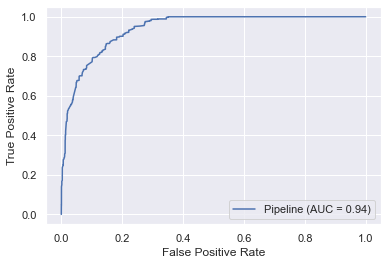

In [180]:
plot_roc_curve(pipe_abc_bench2, X_test, y_test)

> #### Creating Logistic Regression Benchmark 1 - smote, PF

In [115]:
lr_bal = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=2021)

transformer_lr_bench1 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_lr_bench1 = imbPipeline([
    ('transformer', transformer_lr_bench1),
    ('smote', smote),
    ('lr', lr_bal)
])

In [116]:
lr_bench1_cv = cross_val_score(pipe_lr_bench1, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV LR Benchmark1:', lr_bench1_cv)
print('CV LR Benchmark1 Mean:', lr_bench1_cv.mean())

CV LR Benchmark1: [0.85799184 0.86155714 0.86042644 0.85971463 0.86153442]
CV LR Benchmark1 Mean: 0.86024489065023


> #### Creating Naive Bayes GaussianNB Benchmark 1 - smote, PF

In [124]:
gaus = GaussianNB()

transformer_gaus_bench1 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_gaus_bench1 = imbPipeline([
    ('transformer', transformer_gaus_bench1),
    ('smote', smote),
    ('gaus', gaus)
])

In [126]:
gaus_bench1_cv = cross_val_score(pipe_gaus_bench1, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV Gaus Benchmark1:', gaus_bench1_cv)
print('CV Gaus Benchmark1 Mean:', gaus_bench1_cv.mean())

CV Gaus Benchmark1: [0.81562579 0.81537054 0.8157392  0.81517946 0.81551128]
CV Gaus Benchmark1 Mean: 0.8154852554752153


## Creating Tuned Models - 1

> #### DTC Tuned 1 - smote

In [76]:
dtc = DecisionTreeClassifier(random_state=2021)
smote = SMOTE(random_state=2021)

transformer_dtc_tuned1 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour'])
], remainder='passthrough')

pipe_dtc_tuned1 = imbPipeline([
    ('transformer', transformer_dtc_tuned1),
    ('smote', smote),
    ('dtc', dtc)
])

In [77]:
pipe_dtc_tuned1.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal', OrdinalEncoder(),
                                    ['year', 'month', 'day', 'hour'])])),
  ('smote', SMOTE()),
  ('dtc', DecisionTreeClassifier(random_state=2021))],
 'verbose': False,
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal', OrdinalEncoder(),
                                  ['year', 'month', 'day', 'hour'])]),
 'smote': SMOTE(),
 'dtc': DecisionTreeClassifier(random_state=2021),
 'transformer__n_jobs': None,
 'transformer__remainder': 'passthrough',
 'transformer__sparse_threshold': 0.3,
 'transformer__transformer_weights': None,
 'transformer__transformers': [('ordinal',
   OrdinalEncoder(),
   ['year', 'month', 'day', 'hour'])],
 'transformer__verbose': False,
 'transformer__ordinal': OrdinalEncoder(),
 'transformer__ordinal__cols': None,
 'transformer__ordinal__drop_invariant': Fa

In [78]:
hyperparam_space_dtc1 = {
    'dtc__criterion':['gini', 'entropy'],
    'dtc__max_depth': [100, 200, 300, None], 
    'dtc__splitter': ['best', 'random'],
    'dtc__max_features': [None, 'auto', 'sqrt', 'log2']
}

gridsearch_dtc1 = GridSearchCV(
    pipe_dtc_tuned1,
    param_grid = hyperparam_space_dtc1,
    cv = skfold,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

gridsearch_dtc1.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 25.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'hour'])])),
                                       ('smote', SMOTE()),
                                       ('dtc',
                                        DecisionTreeClassifier(random_state=2021))]),
             n_jobs=-1,
             param_grid={'dtc__criterion': ['gini', 'entropy

In [79]:
# DTC Tuned1 Model CV Result

gridsearch_dtc1_df = pd.DataFrame(gridsearch_dtc1.cv_results_)
gridsearch_dtc1_df.sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtc__criterion,param_dtc__max_depth,param_dtc__max_features,param_dtc__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,104.014297,3.816429,0.473510,0.065710,gini,100,None,best,"{'dtc__criterion': 'gini', 'dtc__max_depth': 1...",1.0,1.0,1.0,0.999999,1.0,1.0,4.046867e-07,1
34,75.387093,6.545816,0.534722,0.075660,entropy,100,auto,best,"{'dtc__criterion': 'entropy', 'dtc__max_depth'...",1.0,1.0,1.0,0.999999,1.0,1.0,4.046867e-07,1
35,62.761397,3.272368,0.488113,0.063395,entropy,100,auto,random,"{'dtc__criterion': 'entropy', 'dtc__max_depth'...",1.0,1.0,1.0,0.999999,1.0,1.0,4.046867e-07,1


In [80]:
dtc_tuned1 = gridsearch_dtc1.best_estimator_
dtc_tuned1_cv = cross_val_score(dtc_tuned1, X_train_val, y_train_val, cv=skfold, scoring='f1', n_jobs=-1)

In [81]:
print("Best DTC Tuned1 Model: ", dtc_tuned1)
print('CV DTC Tuned1:', dtc_tuned1_cv)
print('CV DTC Tuned1 Mean:', dtc_tuned1_cv.mean())
# CV DTC Benchmark1 Mean: 0.9999997976566618

Best DTC Tuned1 Model:  Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['year', 'month', 'day',
                                                   'hour'])])),
                ('smote', SMOTE()),
                ('dtc',
                 DecisionTreeClassifier(max_depth=100, random_state=2021))])
CV DTC Tuned1: [1.         1.         1.         0.99999899 1.        ]
CV DTC Tuned1 Mean: 0.9999997976566618


In [136]:
ypred_dtc_tuned1 = dtc_tuned1.predict(X_test)
print(classification_report(y_test, ypred_dtc_tuned1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19850
           1       1.00      1.00      1.00    617762

    accuracy                           1.00    637612
   macro avg       1.00      1.00      1.00    637612
weighted avg       1.00      1.00      1.00    637612



> #### DTC Tuned 2 - smote, PF

In [82]:
# dtc = DecisionTreeClassifier(random_state=2021)
# smote = SMOTE()

# transformer_dtc_tuned2 = ColumnTransformer([ 
#     ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
# ], remainder='passthrough')

# pipe_dtc_tuned2 = imbPipeline([
#     ('transformer', transformer_dtc_tuned2),
#     ('smote', smote),
#     ('dtc', dtc)
# ])

In [83]:
# hyperparam_space_dtc2 = {
#     'dtc__criterion':['gini', 'entropy'],
#     'dtc__splitter': ['best', 'random'],
#     'dtc__max_features': [None, 'auto', 'sqrt', 'log2']
# }

# gridsearch_dtc2 = GridSearchCV(
#     pipe_dtc_tuned2,
#     param_grid = hyperparam_space_dtc2,
#     cv = skfold,
#     scoring = 'f1',
#     n_jobs = -1,
#     verbose = 1
# )

# gridsearch_dtc2.fit(X_train_val, y_train_val)

> #### XGBC Tuned 1 - smote, PF

In [84]:
xgbc = XGBClassifier(random_state=2021)
smote = SMOTE()

transformer_xgbc_tuned1 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_xgbc_tuned1 = imbPipeline([
    ('transformer', transformer_xgbc_tuned1),
    ('smote', smote),
    ('xgbc', xgbc)
])

In [85]:
pipe_xgbc_tuned1.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal', OrdinalEncoder(),
                                    ['year', 'month', 'day', 'hour']),
                                   ('poly', PolynomialFeatures(include_bias=False),
                                    ['x', 'y', 'z'])])),
  ('smote', SMOTE()),
  ('xgbc',
   XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                 colsample_bynode=None, colsample_bytree=None, gamma=None,
                 gpu_id=None, importance_type='gain', interaction_constraints=None,
                 learning_rate=None, max_delta_step=None, max_depth=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 random_state=2021, reg_alpha=None, reg_lambda=None,
                 scale_pos_weight=None, subsample=None, tree_method=None,


In [86]:
# hyperparam_space_xgbc1 = {
#     'xgbc__n_estimators': [100, 150, 200],
#     'xgbc__importance_type': ['gain', 'weight', 'cover', 'total_gain', 'total_cover']
# }
# xgbc = XGBClassifier(random_state=2021)
# smote = SMOTE()
# gridsearch_xgbc1 = GridSearchCV(
#     pipe_xgbc_tuned1,
#     param_grid = hyperparam_space_xgbc1,
#     cv = skfold,
#     scoring = 'f1',
#     n_jobs = -1,
#     verbose = 1
# )

# gridsearch_xgbc1.fit(X_train_val, y_train_val)

In [87]:
# print("Best DTC Tuned1 Model: ", dtc_tuned1)
# print('CV DTC Tuned1:', dtc_tuned1_cv)
# print('CV DTC Tuned1 Mean:', dtc_tuned1_cv.mean())

> #### Creating Logistic Regression Tuned 1 - smote, PF

In [118]:
lr_bal_tuned1 = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=2021, C=0.01)
smote2 = SMOTE(k_neighbors=5, random_state=2021)

transformer_lr_tuned1 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly2', PolynomialFeatures(degree=3, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_lr_tuned1 = imbPipeline([
    ('transformer', transformer_lr_tuned1),
    ('smote', smote2),
    ('lr', lr_bal_tuned1)
])

In [119]:
lr_bal_tuned1_cv = cross_val_score(pipe_lr_tuned1, X_train_val, y_train_val, cv=skfold, scoring='f1')
print('CV LR Benchmark1:', lr_bal_tuned1_cv)
print('CV LR Benchmark1 Mean:', lr_bal_tuned1_cv.mean())

CV LR Benchmark1: [0.86630745 0.86567939 0.86705822 0.86598626 0.86713936]
CV LR Benchmark1 Mean: 0.8664341351268249


In [143]:
pipe_lr_tuned1.fit(X_train_val, y_train_val)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['year', 'month', 'day',
                                                   'hour']),
                                                 ('poly2',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['x', 'y', 'z'])])),
                ('smote', SMOTE()),
                ('lr',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    random_state=2021, solver='liblinear'))])

In [145]:
ypred_lr_bal_tuned1 = pipe_lr_tuned1.predict(X_test)
print(classification_report(y_test, ypred_lr_bal_tuned1))

              precision    recall  f1-score   support

           0       0.10      0.77      0.17     19850
           1       0.99      0.77      0.86    617762

    accuracy                           0.77    637612
   macro avg       0.54      0.77      0.52    637612
weighted avg       0.96      0.77      0.84    637612



In [146]:
confusion_matrix(y_test, ypred_lr_bal_tuned1)

array([[ 15200,   4650],
       [143524, 474238]], dtype=int64)

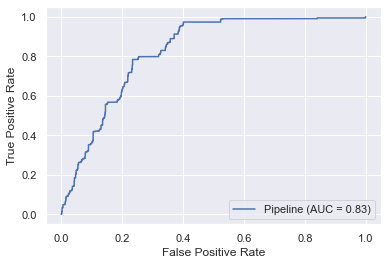

In [147]:
plot_roc_curve(pipe_lr_tuned1, X_test, y_test)

In [157]:
fpr_lr_tuned1, tpr_lr_tuned1, threshold_lr_tuned1 = roc_curve(y_test, prob_lr_tuned1)

In [159]:
roc_lr_tuned1_df = pd.DataFrame({'fpr': fpr_lr_tuned1, 'tpr': tpr_lr_tuned1, 'thr': threshold_lr_tuned1})

In [163]:
roc_lr_tuned1_df.head(3)

,fpr,tpr,thr
0,0.0,0.000000,1.977804
1,0.0,0.000159,0.977804
2,0.0,0.000238,0.977557


In [162]:
roc_lr_tuned1_df[(roc_lr_tuned1_df['fpr']>=0.1) & (roc_lr_tuned1_df['fpr']<=0.3) & (roc_lr_tuned1_df['tpr']>=0.7) & (roc_lr_tuned1_df['tpr']<=0.8)]

,fpr,tpr,thr
3528,0.218640,0.700109,0.564028
3529,0.218640,0.700239,0.563971
3530,0.218640,0.700310,0.563943
3531,0.218640,0.700427,0.563851
3532,0.218841,0.700427,0.563726
...,...,...,...
3975,0.254307,0.797370,0.466892
3976,0.254307,0.797550,0.466482
3977,0.254307,0.797783,0.466476
3978,0.254307,0.797799,0.466300


In [169]:
# thr_lr_tuned1 = 0.466190
thr_lr_tuned1 = 0.37
ypred_thr_lr_tuned1 = np.where(pipe_lr_tuned1.predict_proba(X_test)[:,1] > thr_lr_tuned1, 1, 0)
print(classification_report(y_test, ypred_thr_lr_tuned1))

              precision    recall  f1-score   support

           0       0.15      0.64      0.25     19850
           1       0.99      0.88      0.93    617762

    accuracy                           0.88    637612
   macro avg       0.57      0.76      0.59    637612
weighted avg       0.96      0.88      0.91    637612



In [170]:
confusion_matrix(y_test, ypred_thr_lr_tuned1)

array([[ 12744,   7106],
       [ 71378, 546384]], dtype=int64)

> #### Creating Naive Bayes GaussianNB Tuned 1 - smote, PF

In [127]:
gaus = GaussianNB()

transformer_gaus_tuned1 = ColumnTransformer([ 
    ('ordinal', ce.OrdinalEncoder(), ['year', 'month', 'day', 'hour']),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
], remainder='passthrough')

pipe_gaus_tuned1 = imbPipeline([
    ('transformer', transformer_gaus_tuned1),
    ('smote', smote),
    ('gaus', gaus)
])

In [128]:
pipe_gaus_tuned1.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal', OrdinalEncoder(),
                                    ['year', 'month', 'day', 'hour']),
                                   ('poly', PolynomialFeatures(include_bias=False),
                                    ['x', 'y', 'z'])])),
  ('smote', SMOTE()),
  ('gaus', GaussianNB())],
 'verbose': False,
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal', OrdinalEncoder(),
                                  ['year', 'month', 'day', 'hour']),
                                 ('poly', PolynomialFeatures(include_bias=False),
                                  ['x', 'y', 'z'])]),
 'smote': SMOTE(),
 'gaus': GaussianNB(),
 'transformer__n_jobs': None,
 'transformer__remainder': 'passthrough',
 'transformer__sparse_threshold': 0.3,
 'transformer__transformer_weights': None,
 'transformer__transformers': [('ordinal',

In [129]:
hyperparam_space_gaus1 = {
    'transformer__poly__degree':[2, 3],
    'smote__k_neighbors': [3, 5, 7]
}

gridsearch_gaus1 = GridSearchCV(
    pipe_gaus_tuned1,
    param_grid = hyperparam_space_gaus1,
    cv = skfold,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

gridsearch_gaus1.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 22.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 22.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'hour']),
                                                                        ('poly',
                                                                         PolynomialFeatures(include_bias=False),
                                                                         ['x',
      

In [130]:
# Gaus Tuned1 Model CV Result

gridsearch_gaus1_df = pd.DataFrame(gridsearch_gaus1.cv_results_)
gridsearch_gaus1_df.sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_smote__k_neighbors,param_transformer__poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,676.807393,8.632845,35.333953,6.055306,3,3,"{'smote__k_neighbors': 3, 'transformer__poly__...",0.81589,0.81564,0.815945,0.815449,0.815762,0.815737,0.000178,1
3,263.119151,233.246971,26.571884,23.081438,5,3,"{'smote__k_neighbors': 5, 'transformer__poly__...",0.81589,0.81564,0.815945,0.815449,0.815762,0.815737,0.000178,1
5,238.496486,8.994682,34.969771,10.151521,7,3,"{'smote__k_neighbors': 7, 'transformer__poly__...",0.81589,0.81564,0.815945,0.815449,0.815762,0.815737,0.000178,1


In [133]:
gaus_tuned1 = gridsearch_gaus1.best_estimator_
gaus_tuned1_cv = cross_val_score(gaus_tuned1, X_train_val, y_train_val, cv=skfold, scoring='f1', n_jobs=-1)

In [134]:
print("Best Gaus Tuned1 Model: ", gaus_tuned1)
print('CV Gaus Tuned1:', gaus_tuned1_cv)
print('CV Gaus Tuned1 Mean:', gaus_tuned1_cv.mean())

Best Gaus Tuned1 Model:  Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['year', 'month', 'day',
                                                   'hour']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['x', 'y', 'z'])])),
                ('smote', SMOTE(k_neighbors=3)), ('gaus', GaussianNB())])
CV Gaus Tuned1: [0.81588972 0.81563968 0.81594455 0.8154493  0.81576184]
CV Gaus Tuned1 Mean: 0.815737019299252


In [135]:
ypred_gaus_tuned1 = gaus_tuned1.predict(X_test)
print(classification_report(y_test, ypred_gaus_tuned1))

              precision    recall  f1-score   support

           0       0.06      0.59      0.11     19850
           1       0.98      0.70      0.82    617762

    accuracy                           0.69    637612
   macro avg       0.52      0.64      0.46    637612
weighted avg       0.95      0.69      0.79    637612



In [137]:
confusion_matrix(y_test, ypred_gaus_tuned1)

array([[ 11653,   8197],
       [187232, 430530]], dtype=int64)

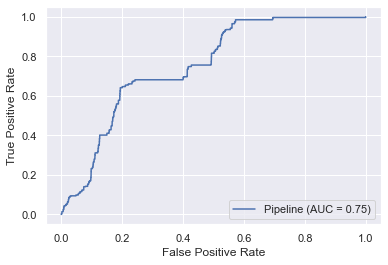

In [140]:
plot_roc_curve(gaus_tuned1, X_test, y_test)

In [175]:
thr_gaus_tuned1 = 0.6
ypred_thr_gaus_tuned1 = np.where(gaus_tuned1.predict_proba(X_test)[:,1] > thr_gaus_tuned1, 1, 0)
print(classification_report(y_test, ypred_thr_gaus_tuned1))

              precision    recall  f1-score   support

           0       0.06      0.59      0.11     19850
           1       0.98      0.70      0.82    617762

    accuracy                           0.69    637612
   macro avg       0.52      0.64      0.46    637612
weighted avg       0.95      0.69      0.79    637612



> #### Tes Voting Classifier

- __Tes VC 1:__

In [88]:
vc_xgbc_dtc1 = VotingClassifier([('pipexgbcbench2', pipe_xgbc_bench2), ('dtctuned1', dtc_tuned1)], voting='soft')

In [89]:
vc_xgbc_dtc1.fit(X_train_val, y_train_val)

[08:10:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('pipexgbcbench2',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['year',
                                                                                 'month',
                                                                                 'day',
                                                                                 'hour']),
                                                                               ('poly',
                                                                                PolynomialFeatures(include_bias=False),
                                             

In [90]:
ypred_vc_xgbc_dtc1 = vc_xgbc_dtc1.predict(X_test)
print(classification_report(y_test, ypred_vc_xgbc_dtc1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19850
           1       1.00      1.00      1.00    617762

    accuracy                           1.00    637612
   macro avg       1.00      1.00      1.00    637612
weighted avg       1.00      1.00      1.00    637612



- __Tes VC 2:__

In [104]:
vc_xgbc_dtc_abc1 = VotingClassifier([('pipexgbcbench2', pipe_xgbc_bench2), ('dtctuned1', dtc_tuned1), ('pipeabcbench2', pipe_abc_bench2)], voting='soft')

In [105]:
vc_xgbc_dtc_abc1.fit(X_train_val, y_train_val)

[09:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('pipexgbcbench2',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['year',
                                                                                 'month',
                                                                                 'day',
                                                                                 'hour']),
                                                                               ('poly',
                                                                                PolynomialFeatures(include_bias=False),
                                             

In [106]:
ypred_vc_xgbc_dtc_abc1 = vc_xgbc_dtc_abc1.predict(X_test)
print(classification_report(y_test, ypred_vc_xgbc_dtc_abc1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19850
           1       1.00      1.00      1.00    617762

    accuracy                           1.00    637612
   macro avg       1.00      1.00      1.00    637612
weighted avg       1.00      1.00      1.00    637612



> #### Test Iseng

In [93]:
samp_df.head()

,Ids,Labels
0,2e69c8bc4_2020-11-29_18,False
1,2e6992f24_2020-11-27_18,True
2,2e69e8dfc_2020-11-28_15,True
3,2e69c47f4_2020-11-26_19,True
4,2e68e64d4_2020-11-29_11,True


In [94]:
test_df.head()

,Ids
0,2e6992a84_2020-11-25_18
1,2e68e62f4_2020-11-29_20
2,2e68e81a4_2020-11-27_10
3,2e69eec04_2020-11-24_7
4,2e698e4a4_2020-11-27_8


In [95]:
# Creating function to convert Ids Table into Proper Independent DF Table for Testing

def ids_to_df(df):
    test_df2 = pd.DataFrame()
    test_df2['s2cell_token'] = df['Ids'].str.split('_').apply(lambda x: x[0])
    test_df2['date'] = df['Ids'].str.split('_').apply(lambda x: x[1])
    test_df2['date'] = test_df2['date'].str.split('-')
    test_df2['hour'] = df['Ids'].str.split('_').apply(lambda x: x[2])
    
    test_df2['year'] = test_df2['date'].apply(lambda x: int(x[0]))
    test_df2['month'] = test_df2['date'].apply(lambda x: int(x[1]))
    test_df2['day'] = test_df2['date'].apply(lambda x: int(x[2]))
    test_df2['hour'] = test_df2['hour'].astype('int')
    
    test_df2['latitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[0])
    test_df2['longitude'] = test_df2['s2cell_token'].apply(s2cell.token_to_lat_lon).apply(lambda x: x[1])
    
    test_df2['x'] = test_df2['latitude'].apply(cos) * test_df2['longitude'].apply(cos)
    test_df2['y'] = test_df2['latitude'].apply(cos) * test_df2['longitude'].apply(sin)
    test_df2['z'] = test_df2['latitude'].apply(sin)
    
    test_df2 = test_df2[['x', 'y', 'z', 'year', 'month', 'day', 'hour']]
    
    return test_df2

In [96]:
ids_to_df(test_df)

,x,y,z,year,month,day,hour
0,0.994031,0.108207,-0.013921,2020,11,25,18
1,0.561143,0.574345,-0.596025,2020,11,29,20
2,0.525794,0.591784,-0.611009,2020,11,27,10
3,0.996602,-0.021315,-0.079557,2020,11,24,7
4,0.972344,0.233176,0.013294,2020,11,27,8
...,...,...,...,...,...,...,...
13836,0.520341,0.621773,-0.585357,2020,11,26,5
13837,0.953392,0.301451,0.013105,2020,11,24,22
13838,0.991486,-0.047556,-0.121218,2020,11,24,10
13839,0.951855,0.294791,-0.084091,2020,11,24,18


- __DTC Bench__

In [97]:
pipe_dtc_bench.fit(X, y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['year', 'month', 'day',
                                                   'hour'])])),
                ('dtc', DecisionTreeClassifier(random_state=2021))])

In [98]:
y_pred_dtc_bench = pipe_dtc_bench.predict(ids_to_df(test_df))

In [99]:
result_dtc_bench = test_df.copy()
result_dtc_bench['Labels'] = y_pred_dtc_bench
result_dtc_bench['Labels'] = np.where(result_dtc_bench['Labels']==1, True, False)

In [100]:
result_dtc_bench

,Ids,Labels
0,2e6992a84_2020-11-25_18,True
1,2e68e62f4_2020-11-29_20,True
2,2e68e81a4_2020-11-27_10,True
3,2e69eec04_2020-11-24_7,True
4,2e698e4a4_2020-11-27_8,True
...,...,...
13836,2e68dd414_2020-11-26_5,True
13837,2e698541c_2020-11-24_22,True
13838,2e69e8e0c_2020-11-24_10,True
13839,2e699a1cc_2020-11-24_18,False


- __vc_xgbc_dtc_abc1 (ENSAMBLE)__

In [108]:
vc_xgbc_dtc_abc1.fit(X, y)

[10:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('pipexgbcbench2',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('ordinal',
                                                                                OrdinalEncoder(),
                                                                                ['year',
                                                                                 'month',
                                                                                 'day',
                                                                                 'hour']),
                                                                               ('poly',
                                                                                PolynomialFeatures(include_bias=False),
                                             

In [109]:
y_pred_vc_xgbc_dtc_abc1 = vc_xgbc_dtc_abc1.predict(ids_to_df(test_df))

In [110]:
result_vc_xgbc_dtc_abc1 = test_df.copy()
result_vc_xgbc_dtc_abc1['Labels'] = y_pred_vc_xgbc_dtc_abc1
result_vc_xgbc_dtc_abc1['Labels'] = np.where(result_vc_xgbc_dtc_abc1['Labels']==1, True, False)

In [111]:
result_vc_xgbc_dtc_abc1

,Ids,Labels
0,2e6992a84_2020-11-25_18,True
1,2e68e62f4_2020-11-29_20,True
2,2e68e81a4_2020-11-27_10,True
3,2e69eec04_2020-11-24_7,True
4,2e698e4a4_2020-11-27_8,True
...,...,...
13836,2e68dd414_2020-11-26_5,True
13837,2e698541c_2020-11-24_22,True
13838,2e69e8e0c_2020-11-24_10,True
13839,2e699a1cc_2020-11-24_18,True


In [112]:
# result_vc_xgbc_dtc_abc1.to_csv('TruePositive_2.csv', index=False)

> #### Test Iseng 2 - REMOVING 'YEAR'

In [107]:
X2 = data_ml[['x', 'y', 'z', 'month', 'day', 'hour']]
y2 = data_ml['Labels']